# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) The libraries needed to run this file. Except for numpy, scikit-learn, pandas, matplotlib

Your peers should be able to use the readme section for instructions and be able to run this file. 

Make sure to keep your answers concise. Maximum number of words is 1000, which you can count with the code below. (You can add around 600 words since we start at around 400).

In [1]:
# If this cell does not work try running `pip install nbformat`

import io
import nbformat
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import imblearn

import re
import csv
from tqdm import tqdm

nb = nbformat.read("Lab1-2021.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 833


## Group Number :

## Student 1 
### Name : Suhaib Basir
### ID : 5059151

## Student 2
### Name : Otte van Dam
### ID : 5096790

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

## Pre-processing

In [2]:
data = "train_data.csv"
df1 = pd.read_csv(data)

#Encoding, Cleaning the data
df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

#Feature Engineering
df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)

df1['accountcode'] = df1['accountcode'].apply(lambda x: re.sub('Account','',x))
df1['accountcode_cc'] = 0
df1.loc[(df1['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df1.loc[(df1['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df1.loc[(df1['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df1.loc[(df1['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

simple_preprocessing_data = df1

## 1. Visualization task – 1 A4

### 1a. Plot visulations 

Normal - cvc response code:  0 . Percentage: 18.521061303815117
Fraud - cvc response code:  0 . Percentage: 89.13043478260869
Normal - cvc response code:  1 . Percentage: 81.39813680341375
Fraud - cvc response code:  1 . Percentage: 10.869565217391305
Normal - cvc response code:  2 . Percentage: 0.003696818623515991
Fraud - cvc response code:  2 . Percentage: 0.0
Normal - cvc response code:  3 . Percentage: 0.07710507414761925
Fraud - cvc response code:  3 . Percentage: 0.0


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


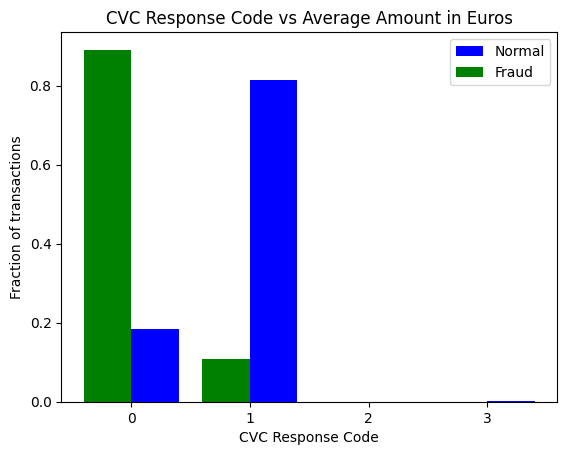

In [3]:
# Make lists of lists to group the normal transactions and the fraud transaction per CVC response code
# Count the amount of transactions per response code
# Lists for normal transactions
cvc_response_codes = []
transactions = []

# Lists for fraud transactions
cvc_response_codes_fraud = []
transactions_fraud = []

# For every cvc response code append a list to the lists and start the counter at 0
for i in range(4):
    cvc_response_codes.append([])
    transactions.append(0)

    cvc_response_codes_fraud.append([])
    transactions_fraud.append(0)

#Add the values to the lists
for row in df1.values:
    # row[9] returns the cvc response code
    cvc_code = row[9]
    # row[14] == 1 means a fraud transaction
    if row[14] == 1:
        #-0.2 so the barplots are next to each other
        cvc_response_codes_fraud[cvc_code].append(cvc_code - 0.2)
        transactions_fraud[cvc_code] += 1
    else:
        #+0.2 so the barplots are next to each other
        cvc_response_codes[cvc_code].append(cvc_code + 0.2)
        transactions[cvc_code] += 1

# Get the number of normal transactions and fraud transactions
number_of_normal_transactions = np.sum(transactions)
number_of_fraud_transactions = np.sum(transactions_fraud)

for i in range(len(cvc_response_codes)):
    # Get the response code by taking the mean of all the response codes
    cvc_response_codes[i] = np.mean(cvc_response_codes[i])
    # Set transactions to the fraction of total transactions
    transactions[i] = transactions[i] / number_of_normal_transactions
    print('Normal - cvc response code: ', i, '. Percentage:', transactions[i] * 100)

    cvc_response_codes_fraud[i] = np.mean(cvc_response_codes_fraud[i])
    # Set transactions to the fraction of total transactions
    transactions_fraud[i] = transactions_fraud[i] / number_of_fraud_transactions

    print('Fraud - cvc response code: ', i, '. Percentage:', transactions_fraud[i] * 100)

plt.bar(cvc_response_codes, transactions, color = 'b', width = 0.4, label = 'Normal')
plt.bar(cvc_response_codes_fraud, transactions_fraud, color = 'g', width = 0.4, label = 'Fraud')

plt.xticks([0, 1, 2, 3], [0, 1, 2, 3])
# Add axis labels and a title
plt.xlabel('CVC Response Code')
plt.ylabel('Fraction of transactions')
plt.title('CVC Response Code vs Average Amount in Euros')

# Add a legend
plt.legend()

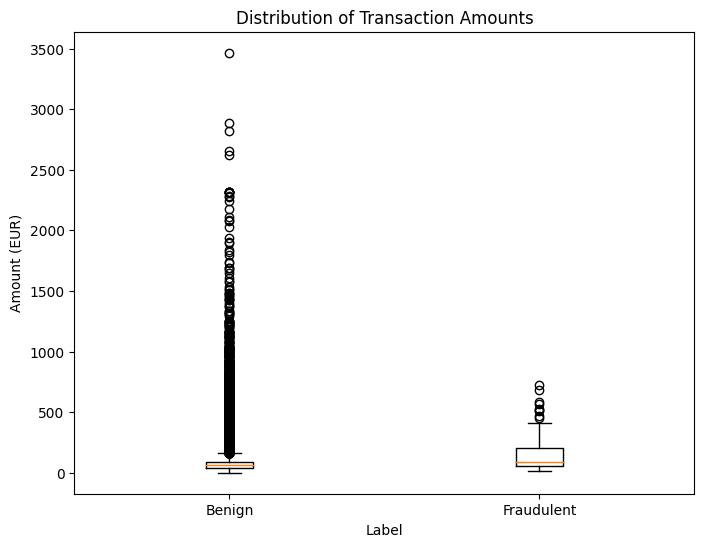

label
0     77.474370
1    146.040479
Name: amount_eur, dtype: float64


In [4]:
# Get a list of all the normal transactions and all the fraud transactions
benign_samples = df1[df1['label'] == 0]
fraudulent_samples = df1[df1['label'] == 1]

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(8, 6))

# Combine the benign and fraudulent samples data into a single list
data = [benign_samples['amount_eur'], fraudulent_samples['amount_eur']]

# Plot side-by-side boxplots
ax.boxplot(data, labels=['Benign', 'Fraudulent'])

# Set labels and title
ax.set_xlabel('Label')
ax.set_ylabel('Amount (EUR)')
ax.set_title('Distribution of Transaction Amounts')

# Display the plot
plt.show()

# mean for amount_eur for fraud and non-fraud transactions
print(df1.groupby('label')['amount_eur'].mean())

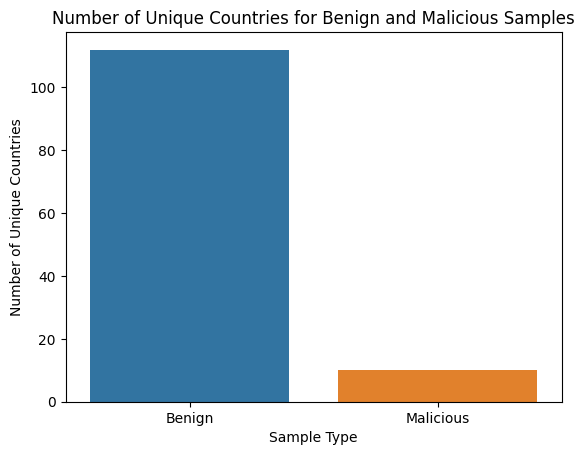

In [5]:
# Count the number of unique countries for benign and malicious samples
benign = df1[df1['label'] == 0]['issuercountrycode'].nunique()
malicious = df1[df1['label'] == 1]['issuercountrycode'].nunique()

# Create a bar plot
sns.barplot(x=['Benign', 'Malicious'], y=[benign, malicious])

# Add labels and title
plt.xlabel('Sample Type')
plt.ylabel('Number of Unique Countries')
plt.title('Number of Unique Countries for Benign and Malicious Samples')

# Display the plot
plt.show()

### 1b. Describe the visualizations and provide relavant explanations of features and relations.

The first graph shows that most (90%) of the malicious transactions have a CVC response code of 0, which is unknown. Around 10% has a CVC response code of 1, which is a match. None of the malicious transactions have no match or not checked. For the normal transactions, most of the CVC response codes are a match with 80%. A bit less than 20% is unkown and there are some 'no match' and 'not checked' responses but those are so few that they are not visible in the graph.

in the second graph we see the distribution of transaction amounts between the fraudulent and benign cases visualised in a boxplot. We can see that there are clearly a lot more data points for the benign cases and far fewer for the fraudulent cases. It is also interesting to see that the benign cases have much higher outliers as this indicates that there are occasional instances of very large transaction amounts in the benign cases. On the other hand, the fraudulent cases generally exhibit smaller transaction amounts with very few or no outliers. This suggests that fraudulent transactions tend to be smaller in magnitude compared to benign transactions. However, the mean of the fraudulent cases (146.04) is higher than that of the benign cases (77.47). 

In the final graph we have visualised the number of unique countries where benign and malicious samples have been collected from. We have plotted this as a bar chart. From the visual, we can see that only a handful of countries (approximately 10) have had cases of fraudulent transaction, which indicates that fraudulent transactions are localised to a few specific countries. On the other hand, the number of countries associated with benign transactions is much larger, indicating a wider distribution of normal transactions across various regions. Additionally, the significant disparity in the number of countries between benign and malicious samples highlights the imbalanced nature of the dataset, with the majority of samples being benign transactions. It's important to consider this class imbalance when developing and evaluating machine learning models to ensure fair and accurate performance assessment.


## More preprocessing

In [6]:
unique_issuer_cc = df1['issuercountrycode'].unique()
unique_shopper_cc = df1['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
lb = LabelBinarizer()
y = lb.fit_transform(df1['issuercountrycode'])

# Create a new DataFrame with the transformed 'issuercountrycode' column
df2 = pd.DataFrame(y, columns=['issuercountrycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'issuercountrycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('issuercountrycode', axis=1), df2], axis=1)

y = lb.fit_transform(df1['shoppercountrycode'])

# Create a new DataFrame with the transformed 'issuercountrycode' column
df2 = pd.DataFrame(y, columns=['shoppercountrycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'issuercountrycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('shoppercountrycode', axis=1), df2], axis=1)

lb2 = LabelBinarizer()
y = lb2.fit_transform(df1['txvariantcode'])

# Create a new DataFrame with the transformed 'txvariantcode' column
df2 = pd.DataFrame(y, columns=['txvariantcode_'+str(i) for i in range(y.shape[1])])

# Replace the 'txvariantcode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('txvariantcode', axis=1), df2], axis=1)

lb3 = LabelBinarizer()
y = lb3.fit_transform(df1['currencycode'])

# Create a new DataFrame with the transformed 'currencycode' column
df2 = pd.DataFrame(y, columns=['currencycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'currencycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('currencycode', axis=1), df2], axis=1)

lb4 = LabelBinarizer()
y = lb4.fit_transform(df1['shopperinteraction'])

# Create a new DataFrame with the transformed 'shopperinteraction' column
df2 = pd.DataFrame(y, columns=['shopperinteraction_'+str(i) for i in range(y.shape[1])])

# Replace the 'shopperinteraction' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('shopperinteraction', axis=1), df2], axis=1)

lb5 = LabelBinarizer()
y = lb5.fit_transform(df1['accountcode_cc'])

# Create a new DataFrame with the transformed 'accountcode_cc' column
df2 = pd.DataFrame(y, columns=['accountcode_cc_'+str(i) for i in range(y.shape[1])])

# Replace the 'accountcode_cc' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('accountcode_cc', axis=1), df2], axis=1)

# drop id, mail_id, ip_id, card_id
df1 = df1.drop(['Id','mail_id','ip_id','card_id', 'amount', 'accountcode'], axis=1)

processed_df1 = df1

### Encoding data

## Classification task 

### Training models

### 4a. Print relevant plots and metrics with clear headings.

In [7]:
# Get the data right after processing it. Without rank swapping and smothing.
df1 = processed_df1

# Separate features and labels
X = df1.drop('label', axis=1)
y = df1['label']

y = y.astype('int')

# Define the number of folds
n_splits = 10

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize listst for every classifier for the prediction, probability and truth.
y_proba_all_dec_tree = []
y_predicts_all_dec_tree = []
y_truth_all_dec_tree = []

y_proba_all_mlp = []
y_predicts_all_mlp = []
y_truth_all_mlp = []

round_counter = 0
# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    round_counter += 1
    print('round ', round_counter, ' of ', n_splits)

    # Split the data into training and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # smote the training data using SMOTE from imblearn
    sm = imblearn.over_sampling.SMOTE(sampling_strategy=0.1, random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    # Create and train the Decision Tree Classifier
    clf_tree = DecisionTreeClassifier(random_state=42)
    clf_tree.fit(X_train, y_train)

    # Make predictions on the test set
    y_proba = clf_tree.predict_proba(X_test)
    y_pred = clf_tree.predict(X_test)
    y_proba_all_dec_tree.extend(y_proba)
    y_predicts_all_dec_tree.extend(y_pred)
    y_truth_all_dec_tree.extend(y_test)
    print('Decision Tree done')

    # use a neural network for classification
    # Create and train the Multi-Layer Perceptron Classifier
    clf_mlp = MLPClassifier(random_state=42)
    clf_mlp.fit(X_train, y_train)

    # Make predictions on the test set
    y_proba = clf_mlp.predict_proba(X_test)
    y_pred = clf_mlp.predict(X_test)
    y_proba_all_mlp.extend(y_proba)
    y_predicts_all_mlp.extend(y_pred)
    y_truth_all_mlp.extend(y_test)
    print('MLP done')

round  1  of  10
Decision Tree done


In [ ]:
# Calculate confusion_mat score
confusion_mat_dec_tree = confusion_matrix(y_truth_all_dec_tree, y_predicts_all_dec_tree)

# Print the confusion_mat score
print("confusion_mat score decision tree:")
print(confusion_mat_dec_tree)

# Calculate confusion_mat score
confusion_mat_mlp = confusion_matrix(y_truth_all_mlp, y_predicts_all_mlp)

# Print the confusion_mat score
print("confusion_mat score mlp:")
print(confusion_mat_mlp)

In [ ]:
# Get the probability of being a fraud transaction for every sample
one_prob_dec_tree = [lst[1] for lst in y_proba_all_dec_tree]
fpr, tpr, thresholds = roc_curve(y_truth_all_dec_tree, one_prob_dec_tree)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Decision Tree')
plt.legend(loc="lower right")
plt.show()

# Get the probability of being a fraud transaction for every sample
one_prob_mlp = [lst[1] for lst in y_proba_all_mlp]
fpr, tpr, thresholds = roc_curve(y_truth_all_mlp, one_prob_mlp)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic MLP')
plt.legend(loc="lower right")
plt.show()

# Get the probability of being a fraud transaction for every sample
one_prob_log = [lst[1] for lst in y_proba_all_log]
fpr, tpr, thresholds = roc_curve(y_truth_all_log, one_prob_log)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Logistic Regression')
plt.legend(loc="lower right")

### 4b. Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

All categorical data is encoded with one hot encoding (don't be fooled by labelBinerizer() this actually encodes the data like onehot and not binary encoding). This is done so there is no relationship between categories. This is also good for the explainability of for instance a decision tree. A decision tree says country_number_23 > 0.5 now which gives true if the transaction is done from country 23 and false otherwise. We also dropped the accountcode and every identifier such as an email or ip-address since these belong to one single transactions and are different for every transaction. Next to that we dropped the amount since we already have amount in euros which is more generalisable.

For the black box classifier, we chose a multilayer perceptron.

For the white box classifier, we chose a decision tree. This is because for every single sample you can follow the three which gives a great insight on why a sample is labeled fraud or not. It can also give a general direction of what values are seen as fraudulent and which are not. It still performs good

## 5. Bonus task – 1 A4

### 5a. Provide code and report below